In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Deep Q-Networks in Pytorch

In this notebook we will implement deep q-learning using Pytorch.

In [2]:
#Needed for gym as I am using a Virtual Environment
import sys
sys.path.append('/Users/rthakur/Documents/RL_Assignments/.venv/lib/python3.8/site-packages')

In [3]:
import copy
import math
import os
from collections import namedtuple

from gym.utils import play
import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import random

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

pygame 2.0.3 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


#### Environments

In this notebook, we will implement DQN and run it on four environments which have a continuous state-space and discrete action-space.  There are:

 * CartPole:  Balance a pole on a moving cart (https://gym.openai.com/envs/CartPole-v1/).
 * Mountain Car:  Gather momentum to climb a hill (https://gym.openai.com/envs/MountainCar-v0/).
 * AcroBot:  A two-link robot needs to swing and reach the area above a line (https://gym.openai.com/envs/Acrobot-v1/).
 * LunarLander:  A spaceship needs to fly and land in the landing spot.  (https://gym.openai.com/envs/LunarLander-v2/).

In [4]:
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'mountaincar': gym.make('MountainCar-v0'),
    'acrobot': gym.make('Acrobot-v1'),
    'lunarlander': gym.make('LunarLander-v2'),
}

These environments are particularly cool because they all include a graphical visualization which we can use to visualize our learned policies.  Run the following cell and click the buttons to run the visualization with a random policy.

In [5]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """
    if policy is None:

        def policy(state):
            return env.action_space.sample()

    state = env.reset()
    env.render()
    while True:
        action = policy(state)
        state, _, done, _ = env.step(action)
        env.render()
        if done:
            break
    env.close()

2021-11-07 15:51:02.830 Python[2702:93130] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/sd/gpl4cvx11js9jwvpk7zwlsp00000gn/T/org.python.python.savedState


In [6]:
#  Jupyter UI

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = envs[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False

buttons = []
for env_id in envs.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)



Click a button to run a random policy:


### Smoothing

In this notebook, we'll do some plotting of noisy data, so here is the smoothing function.

In [7]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

### Exponential $\epsilon$-Greedy Decay

This time we'll switch from using a linear decay to an exponential decay, defined as
$$\epsilon_t = a \exp (b t)$$
where $a$ and $b$ are the parameters of the schedule.

The interface to the scheduler is the same as in the linear case  i.e. it receives the initial value, the final value, and in how many steps to go from initial to final.  Your task is to compute parameters `a` and `b` to make the scheduler work as expected.

In [8]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # determine the `a` and `b` parameters such that the schedule is correct
        self.a = value_from
        self.b = (np.log(value_to) - np.log(self.a))/(num_steps-1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """
        if step <= 0:
            return self.value_from
        elif step >= self.num_steps-1:
            return self.value_to
        else:
            value = self.a * np.exp(self.b * (step))
        
        return value


# test code, do not edit


def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == round(value, ndigits):
        raise Exception(
            f'For step {step}, the scheduler returned {v} instead of {value}'
        )


_schedule = ExponentialSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.141421356237309515)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = ExponentialSchedule(0.5, 0.1, 5)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.33437015248821106)
_test_schedule(_schedule, 2, 0.22360679774997905)
_test_schedule(_schedule, 3, 0.14953487812212207)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.1)
del _schedule

###  Replay Memory

Now we will implement the Replay Memory, the data-structure where we store previous experiences so that we can re-sample and train on them.

In [9]:
# Batch namedtuple, i.e. a class which contains the given attributes
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer.
            - state_size: Size of the state-space features for the environment.
        """
        self.max_size = max_size
        self.state_size = state_size

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state:  1-D np.ndarray of state-features.
        :param action:  integer action.
        :param reward:  float reward.
        :param next_state:  1-D np.ndarray of state-features.
        :param done:  boolean value indicating the end of an episode.
        """

        #store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`
        self.states[self.idx] = torch.from_numpy(state)
        self.actions[self.idx] = torch.tensor(action)
        self.rewards[self.idx] = torch.tensor(reward)
        self.next_states[self.idx] = torch.from_numpy(next_state)
        self.dones[self.idx] = torch.tensor(done)
        
        # DO NOT EDIT
        # circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size:  Number of transitions to sample.
        :rtype: Batch
        """

        # randomly sample an appropriate number of
        # transitions *without replacement*.  If the buffer contains less than
        # `batch_size` transitions, return all of them.  The return type must
        # be a `Batch`.
        if self.size < batch_size:
            batch = Batch(self.states,self.actions,self.rewards,self.next_states,self.dones)
            return batch
        sample_indices = np.random.choice(self.size,batch_size,replace=False)
        batch = Batch(self.states[sample_indices],self.actions[sample_indices],
                      self.rewards[sample_indices],self.next_states[sample_indices],
                      self.dones[sample_indices])
                     
        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env:  Openai Gym environment
        :param num_steps:  Number of steps to populate the
        """
        # run a random policy for `num_steps` time-steps and
        # populate the replay memory with the resulting transitions.
        state = env.reset()
        for steps in range(num_steps):
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            self.add(state,action,reward,next_state,done)
            if done:
                state = env.reset()
            else:
                state = next_state

In [10]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=256):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        #  define the layers of your model such that
        # * there are `num_layers` nn.Linear modules / layers
        # * all activations except the last should be ReLU activations
        #   (this can be achieved either using a nn.ReLU() object or the nn.functional.relu() method)
        # * the last activation can either be missing, or you can use nn.Identity()
        layers = []
        layers.append(nn.Linear(self.state_dim,self.hidden_dim))
        layers.append(nn.ReLU())
        for i in range(self.num_layers - 2):
            layers.append(nn.Linear(self.hidden_dim,self.hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim,self.action_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space.
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space.  This represents the Q values Q(s, .).
        """
        # use the defined layers and activations to compute
        # the action-values tensor associated with the input states.
        return self.net(states)

    # utility methods for cloning and storing models.  DO NOT EDIT
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }


# test code, do not edit


def _test_dqn_forward(dqn_model, input_shape, output_shape):
    """Tests that the dqn returns the correctly shaped tensors."""
    inputs = torch.torch.randn((input_shape))
    outputs = dqn_model(inputs)

    if not isinstance(outputs, torch.FloatTensor):
        raise Exception(
            f'DQN.forward returned type {type(outputs)} instead of torch.Tensor'
        )

    if outputs.shape != output_shape:
        raise Exception(
            f'DQN.forward returned tensor with shape {outputs.shape} instead of {output_shape}'
        )

    if not outputs.requires_grad:
        raise Exception(
            f'DQN.forward returned tensor which does not require a gradient (but it should)'
        )


dqn_model = DQN(10, 4)
_test_dqn_forward(dqn_model, (64, 10), (64, 4))
_test_dqn_forward(dqn_model, (2, 3, 10), (2, 3, 4))
del dqn_model

dqn_model = DQN(64, 16)
_test_dqn_forward(dqn_model, (64, 64), (64, 16))
_test_dqn_forward(dqn_model, (2, 3, 64), (2, 3, 16))
del dqn_model

# testing custom dump / load
dqn1 = DQN(10, 4, num_layers=10, hidden_dim=20)
dqn2 = DQN.custom_load(dqn1.custom_dump())
assert dqn2.state_dim == 10
assert dqn2.action_dim == 4
assert dqn2.num_layers == 10
assert dqn2.hidden_dim == 20

###  Single batch-update

In [11]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    # compute the values and target_values tensors using the
    # given models and the batch of data.
    states,actions,rewards,next_states,dones = batch
    not_done_mask = torch.logical_not(dones)
    values = dqn_model(states).gather(1,actions)
    with torch.no_grad():
        target_values =  rewards + gamma * dqn_target(next_states).max(1)[0].unsqueeze(1)*not_done_mask
    # DO NOT EDIT FURTHER

    assert (
        values.shape == target_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'

    # testing that the value tensor requires a gradient,
    # and the target_values tensor does not
    assert values.requires_grad, 'values tensor should not require gradients'
    assert (
        not target_values.requires_grad
    ), 'target_values tensor should require gradients'

    # computing the scalar MSE loss between computed values and the TD-target
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [12]:
def train_dqn(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes.  The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # check that environment states are compatible with our DQN representation
    assert (
        isinstance(env.observation_space, gym.spaces.Box)
        and len(env.observation_space.shape) == 1
    )

    # get the state_size from the environment
    state_size = env.observation_space.shape[0]

    # initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())

    # initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # use this to indicate the index of the current episode
    t_episode = 0  # use this to indicate the time-step inside current episode

    state = env.reset()  # initialize state of first episode
    # iterate for a total of `num_steps` steps
    pbar = tqdm.notebook.tnrange(num_steps)
    for t_total in pbar:
        # use t_total to indicate the time-step from the beginning of training

        # save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory
        num = random.random()
        eps = exploration.value(t_total)
        if num > eps:
            with torch.no_grad():
                action = dqn_model(torch.from_numpy(state)).max(0)[1].item()
        else:
            action = env.action_space.sample()
            
        next_state,reward,done,_ = env.step(action)
        memory.add(state,action,reward,next_state,done)
        rewards.append(reward)
        
        
        # once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method!)
        if t_total % 4 == 0:
            batch = memory.sample(batch_size)
            batch_loss = train_dqn_batch(optimizer,batch,dqn_model,dqn_target,gamma)
            losses.append(batch_loss)
        # once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods!)
        if t_total % 10000 == 0:
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done == True:
            state = env.reset()
            lengths.append(t_episode)
            i_episode +=1
            G = np.sum([np.power(gamma,i) * rewards[i] for i in range(len(rewards))])
            returns.append(G)
            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )
            t_episode = 0
            rewards = []
        else:
            state = next_state
            t_episode += 1
            


    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

###  Evaluation of DQN on the 4 environments

#### CartPole


In [21]:
#100 or 1000 window size
env = envs['cartpole']
gamma = 0.99

num_steps = 1_500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)
np.save('cartpole_returns.npy',returns)
np.save('cartpole_lengths.npy',lengths)
np.save('cartpole_losses.npy',losses)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

  0%|          | 0/1500000 [00:00<?, ?it/s]

In [13]:
def plot_data(x):
    plt.figure(figsize=(15,7))
    plt.plot(x,color = 'red')
    rolling_av = rolling_average(x,window_size = 100)
    plt.plot(rolling_av,color = 'blue')

In [15]:
cp_loss = np.load('cartpole_losses.npy')
cp_returns = np.load('cartpole_returns.npy')
cp_lens = np.load('cartpole_lengths.npy')

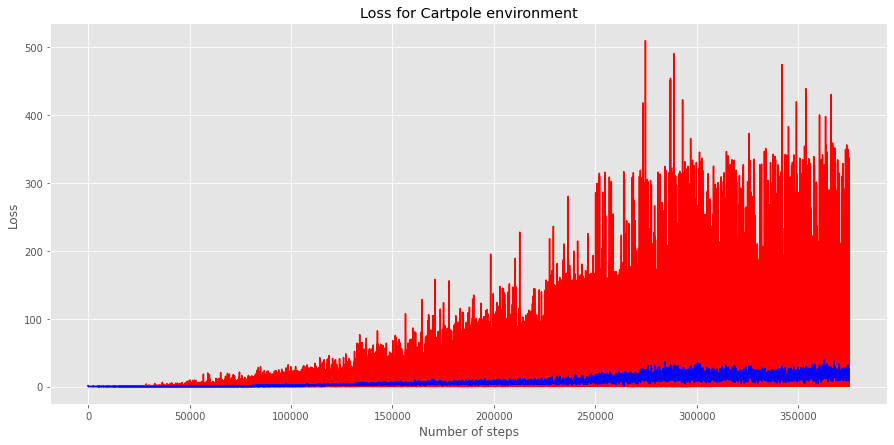

In [16]:
%matplotlib inline
plot_data(cp_loss)
plt.xlabel("Number of steps")
plt.ylabel("Loss")
plt.title("Loss for Cartpole environment")
plt.show()

Text(0.5, 1.0, 'Length of episodes for Cartpole environment')

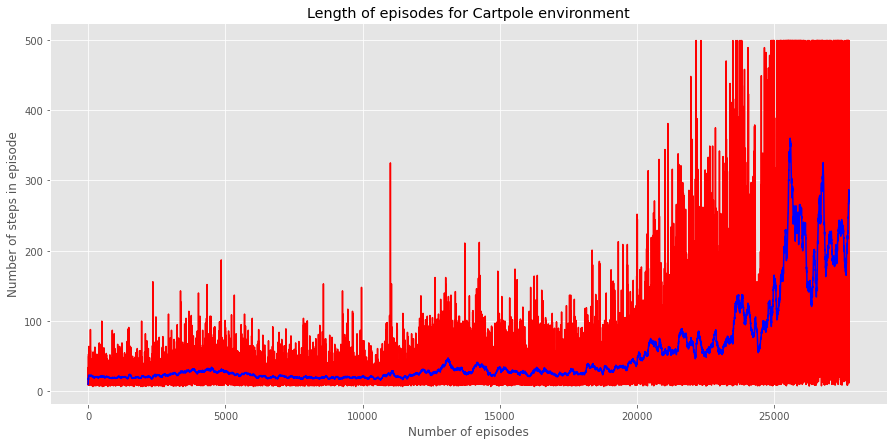

In [17]:
%matplotlib inline
plot_data(cp_lens)
plt.xlabel("Number of episodes")
plt.ylabel("Number of steps in episode")
plt.title("Length of episodes for Cartpole environment")

Text(0.5, 1.0, 'Returns per episode for Cartpole environment')

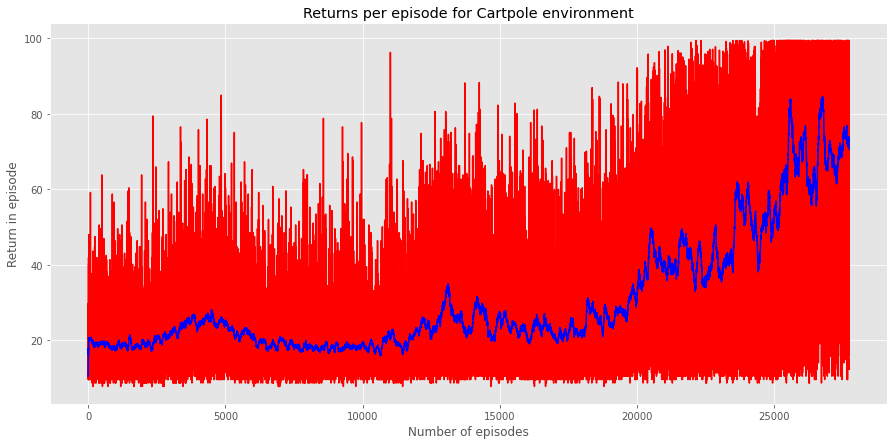

In [18]:
%matplotlib inline
plot_data(cp_returns)
plt.xlabel("Number of episodes")
plt.ylabel("Return in episode")
plt.title("Returns per episode for Cartpole environment")

#### MountainCar


In [22]:
env = envs['mountaincar']
gamma = 0.99

num_steps = 1_500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)
np.save('mountain_returns.npy',returns)
np.save('mountain_lengths.npy',lengths)
np.save('mountain_losses.npy',losses)
assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

  0%|          | 0/1500000 [00:00<?, ?it/s]

In [65]:
mc_loss = np.load('mountain_losses.npy')
mc_returns = np.load('mountain_returns.npy')
mc_lens = np.load('mountain_lengths.npy')

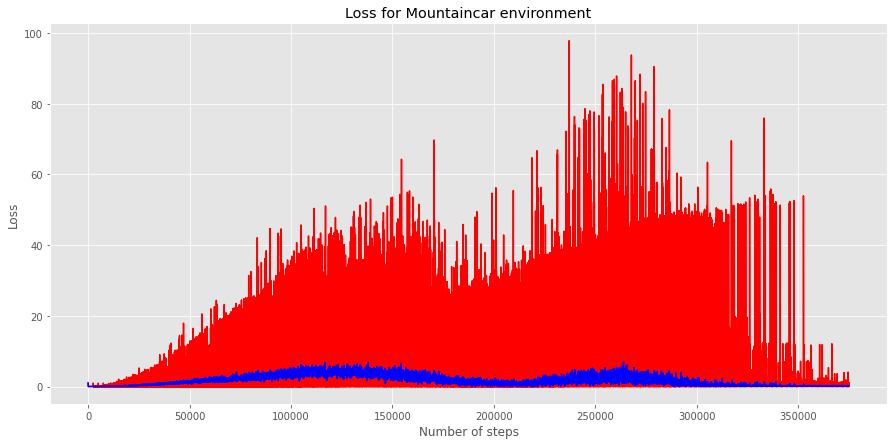

In [62]:
%matplotlib inline
plot_data(mc_loss)
plt.xlabel("Number of steps")
plt.ylabel("Loss")
plt.title("Loss for Mountaincar environment")
plt.show()

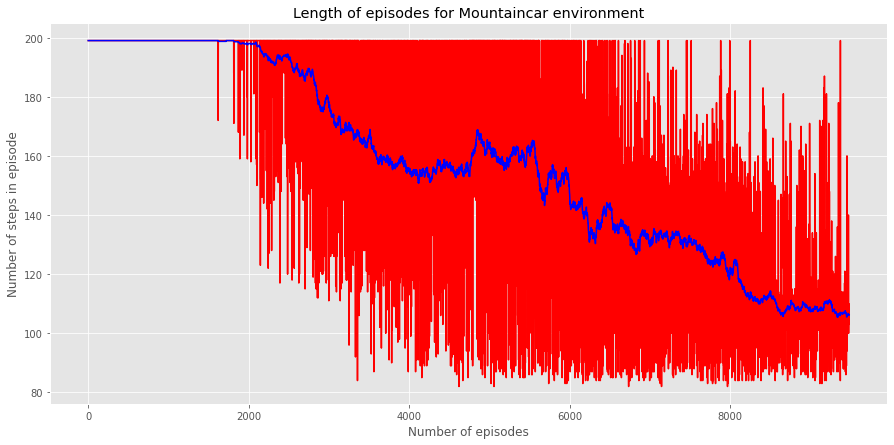

In [66]:
%matplotlib inline
plot_data(mc_lens)
plt.xlabel("Number of episodes")
plt.ylabel("Number of steps in episode")
plt.title("Length of episodes for Mountaincar environment")
plt.show()

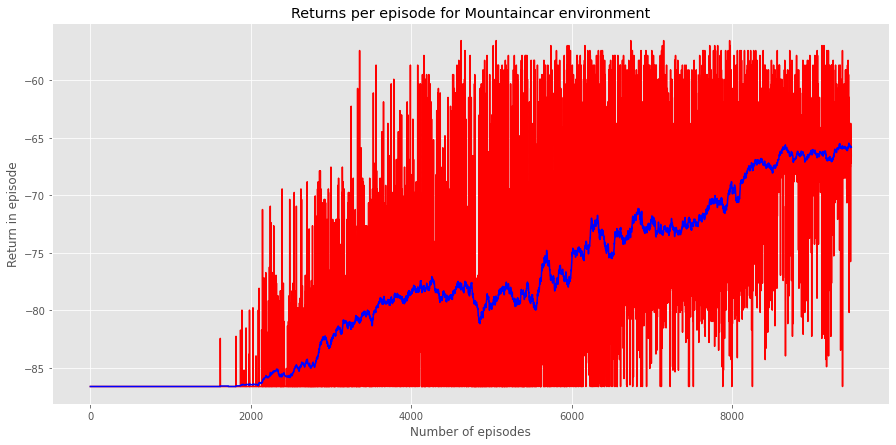

In [64]:
%matplotlib inline
plot_data(mc_returns)
plt.xlabel("Number of episodes")
plt.ylabel("Return in episode")
plt.title("Returns per episode for Mountaincar environment")
plt.show()

#### AcroBot


In [23]:
env = envs['acrobot']
gamma = 0.99

num_steps = 1_500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)
np.save('acrobot_returns.npy',returns)
np.save('acrobot_lengths.npy',lengths)
np.save('acrobot_losses.npy',losses)
assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

  0%|          | 0/1500000 [00:00<?, ?it/s]

In [67]:
ab_loss = np.load('acrobot_losses.npy')
ab_returns = np.load('acrobot_returns.npy')
ab_lens = np.load('acrobot_lengths.npy')

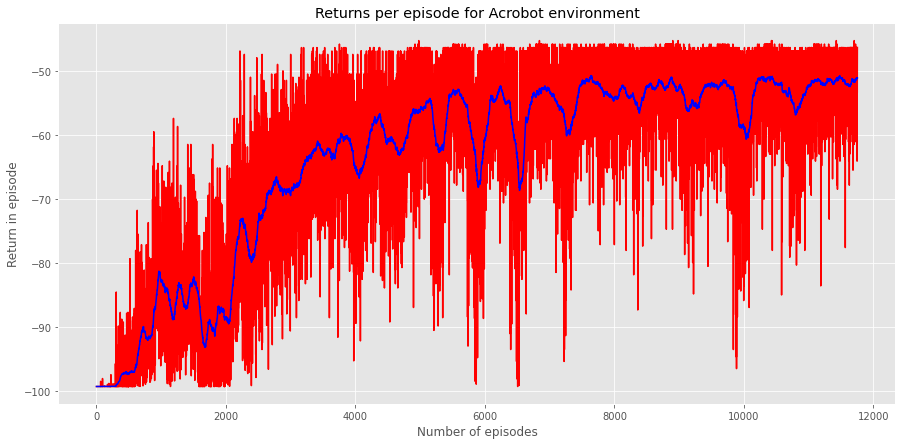

In [71]:
%matplotlib inline
plot_data(ab_returns)
plt.xlabel("Number of episodes")
plt.ylabel("Return in episode")
plt.title("Returns per episode for Acrobot environment")
plt.show()

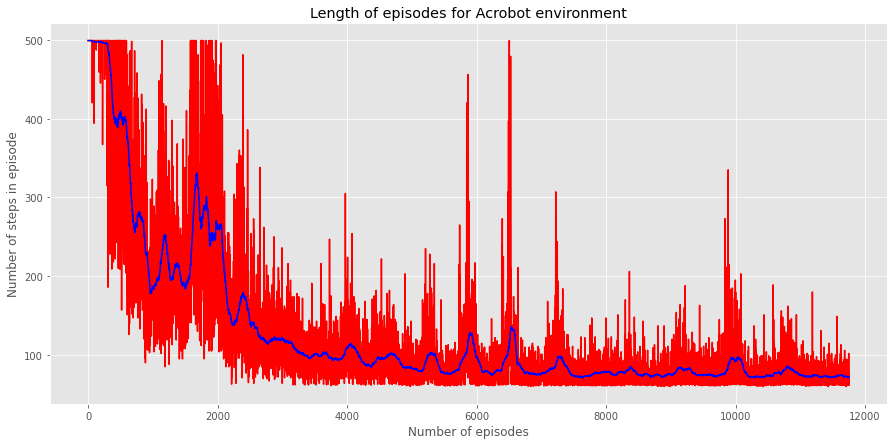

In [70]:
%matplotlib inline
plot_data(ab_lens)
plt.xlabel("Number of episodes")
plt.ylabel("Number of steps in episode")
plt.title("Length of episodes for Acrobot environment")
plt.show()

Text(0.5, 1.0, 'Loss for Acrobot environment')

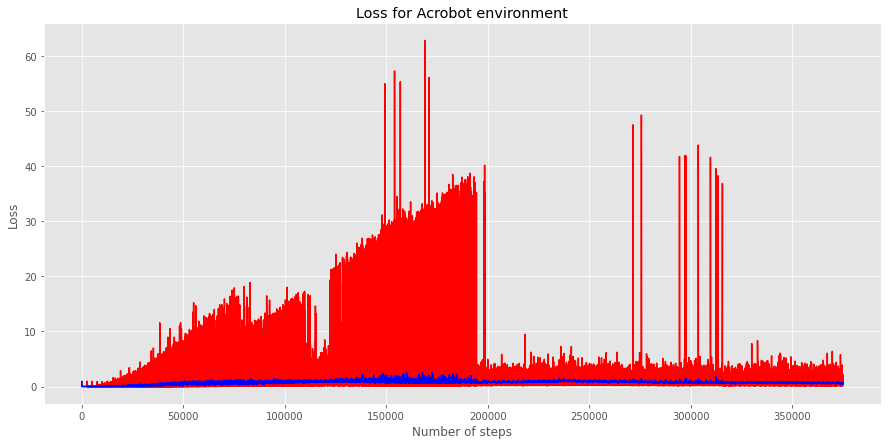

In [69]:
%matplotlib inline
plot_data(ab_loss)
plt.xlabel("Number of steps")
plt.ylabel("Loss")
plt.title("Loss for Acrobot environment")

#### LunarLander


In [19]:
env = envs['lunarlander']
gamma = 0.99

num_steps = 1_500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)
np.save('lunar_returns.npy',returns)
np.save('lunar_lengths.npy',lengths)
np.save('lunar_losses.npy',losses)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

  0%|          | 0/1500000 [00:00<?, ?it/s]

In [20]:
l_loss = np.load('lunar_losses.npy')
l_returns = np.load('lunar_returns.npy')
l_lens = np.load('lunar_lengths.npy')

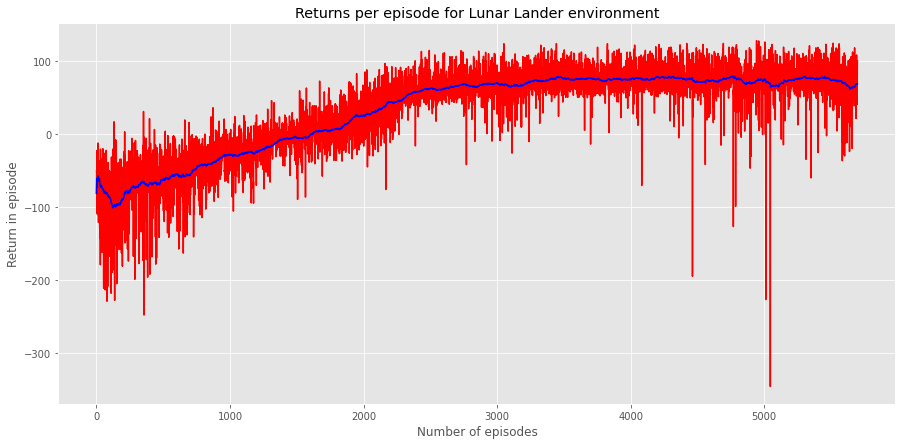

In [21]:
%matplotlib inline
plot_data(l_returns)
plt.xlabel("Number of episodes")
plt.ylabel("Return in episode")
plt.title("Returns per episode for Lunar Lander environment")
plt.show()

Text(0.5, 1.0, 'Loss for Lunar Lander environment')

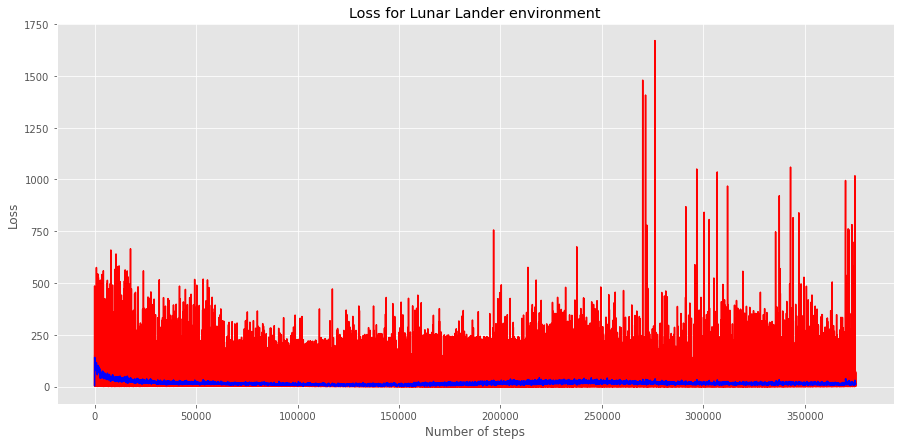

In [22]:
%matplotlib inline
plot_data(l_loss)
plt.xlabel("Number of steps")
plt.ylabel("Loss")
plt.title("Loss for Lunar Lander environment")

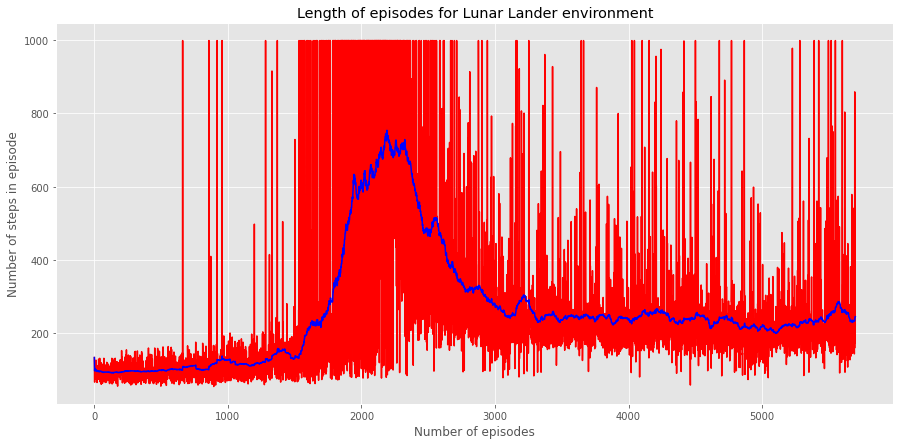

In [23]:
%matplotlib inline
plot_data(l_lens)
plt.xlabel("Number of episodes")
plt.ylabel("Number of steps in episode")
plt.title("Length of episodes for Lunar Lander environment")
plt.show()

### Visualization of the trained policies!

Run the cell below and push the buttons to view the progress of the policy trained using DQN.

In [14]:
buttons_all = []
for key_env, env in envs.items():
    try:
        checkpoint = torch.load(f'checkpoint_{env.spec.id}.pt')
    except FileNotFoundError:
        pass
    else:
        buttons = []
        for key, value in checkpoint.items():
            dqn = DQN.custom_load(value)
            
            def make_callback(env, dqn):
                def button_callback(button):
                    for b in buttons_all:
                        b.disabled = True
                        
                    render(env, lambda state: dqn(torch.tensor(state, dtype=torch.float)).argmax().item())
                    
                    for b in buttons_all:
                        b.disabled = False
                        
                return button_callback
                
            button = widgets.Button(description=f'{key.replace("_", ".")}%')
            button.on_click(make_callback(env, dqn))
            buttons.append(button)
        
        print(f'{key_env}:')
        display(widgets.HBox(buttons))
        buttons_all.extend(buttons)

cartpole:


mountaincar:


acrobot:


lunarlander:


### Analysis


##### CartPole

* 0%) At 0% we are using epsilon=1 which is equivalent to a random policy. Due to random action selection, the cartpole falls very quickly leading to the end of simulation. This can be verified by lengths, returns plots as well. 
* 25%) At 25% we can see interesting behaviour. Agent starts exploiting the strategy that going left always balances the cartpole at required angle for certain time until it hits the wall, giving positive rewards. This policy is better than at 0% but still not even close to optimal 
* 50%) At 50% DQN agent learns that going against momentum of left (i.e. taking right action and using left momentum to its advantage) it can balance the pole for even more amount of time. But in both 50% and 25% angle seems to be more than 15 degrees than vertical
* 75%) At 75% Agent tries to keep a check on angle but in doing so fails to balance the pole for longer period. This behavior seems worse than at 50%. 
* 100%) At 100% also Agent does not seem to have reached optimality most of the times (i.e. keeping angle less than 15 degrees from center, staying in 2.5 units of center) and reward structure keeps fluctuating. But this phase is overall better than previous phases

##### MountainCar

* 0%) At 0% agent has not yet discovered the ideal momentum required to push cart to the top of mountain. Since it explores at 100% rate
* 25%) At 25% we can see that agent goes more back and forth to try getting car to the top. Here we see that it starts discovering (with very little fraction) going reverse to uphill and using the downward force to reach on top. This stage seems better than 0%
* 50%) At 50% agent exploits its previous find of gaining momentum from reverse thrust. But it seems to be exploiting this fact for more number of times than actually required for optimality. Also in this stage agent reaches to its goal. This stage is better than both 25% and 0%. 
* 75%) At 75% agent has almost learned the optimal policy and increases momentum to reach goal quickly. It tries to do such in minimum swings required. This behaviour is better than at 50% 
* 100%)At 100% DQN agent reaches optimality and does exact momentum swings(2) for reaching the goal. The returns and length of episodes are strictly better than previous states.

##### Acrobot

* 0%) At 0% agent explores at 100% rate. But never reaches the goal. It tries to gain momentum by entire arm movement
* 25%) At 25% we see behavior of learning that, there is no requirement to swing top half of the arm, as momentum can be gained by swinging bottom half as well.But here agent reaches goal very rarely due to exploration quotient. We can see this behavior in spike of length of episode
* 50%) At 50% agent tries to swing more frequently to tr gain more momentum. But fails to reach the goal. It takes more time as well to gain momentum
* 75%) At 75% agent learns to use momentum and reaches goal all the time with speed. This phase is better than all previous phases
* 100%) At 100% we see time to reach goal state is even less than 75%. We can assume that agent has reached optimality in this phase

##### LunarLander

* 0%) At 0% agent does not fire any engines and tries to use free fall to its advantage as the policy is random. But crashes
* 25%) At 25% agent tries to fire all the engines to avoid crash from phase before, resulting in not reaching the goal (floating in mid air) or landing in wrong place
* 50%) From this stage agent tries to optimize engine fire behavior to reduce penalty for engine firing and also tries to exploit free fall to its advantage. It mostly follows policy similar to 25% but this time only fires engine of reverse thrust(and not using directions for most of the time). This results in landing at correct place if its starting from correct place above goal state.
* 75%) At 75% agent tries to use thrusters alternatively finding more time without thruster to reduce penalty even more. Here agent reaches goal state 99% of the times and also reaches goal state quickly. This stage is slightly better than previous state.
* 100%) At 100% agent behaves similar to 75% reaching goal but reaches goal all the time and quickly. Also uses thrusters in much better way than previous states. Leading to reach of optimality under e-greedy policy.